In [1]:

%pprint

Pretty printing has been turned OFF



## Let's use our labeled data to evaluate a Conditional Random Fields model

In [2]:

%%time
%run ../py/html_analysis.py

crf = CrfUtilities()

Wall time: 12.6 s



## Test its accuracy

In [3]:

sql_str = f'''
    SELECT
        np.[navigable_parent],
        pos.[pos_symbol]
    FROM
        [Jobhunting].[dbo].[NavigableParents] np INNER JOIN
        [Jobhunting].[dbo].[PartsOfSpeech] pos ON
            pos.[is_header] = np.[is_header] AND
            pos.[is_task_scope] = np.[is_task_scope] AND
            pos.[is_minimum_qualification] = np.[is_minimum_qualification] AND
            pos.[is_preferred_qualification] = np.[is_preferred_qualification] AND
            pos.[is_legal_notification] = np.[is_legal_notification] AND
            pos.[is_job_title] = np.[is_job_title] AND
            pos.[is_office_location] = np.[is_office_location] AND
            pos.[is_job_duration] = np.[is_job_duration] AND
            pos.[is_supplemental_pay] = np.[is_supplemental_pay] AND
            pos.[is_educational_requirement] = np.[is_educational_requirement] AND
            pos.[is_interview_procedure] = np.[is_interview_procedure] AND
            pos.[is_corporate_scope] = np.[is_corporate_scope] AND
            pos.[is_posting_date] = np.[is_posting_date] AND
            pos.[is_other] = np.[is_other];'''
pos_df = pd.DataFrame(crf.su.get_execution_results(crf.cursor, sql_str, verbose=False))
POS_DICT = pos_df.set_index('navigable_parent')['pos_symbol'].to_dict()

In [4]:

HEADER_PATTERN_DICT = s.load_object('HEADER_PATTERN_DICT')
tuples_list = []
for file_name, feature_dict_list in HEADER_PATTERN_DICT.items():
    total = len(feature_dict_list)
    symbol_count = 0
    for feature_dict in feature_dict_list:
        if feature_dict['child_str'] in POS_DICT:
            symbol_count += 1
    #print(f'{file_name}: {symbol_count}/{total}')
    tuples_list.append((file_name, symbol_count/total))
file_names_list = []
for file_name, completed_percentage in sorted(tuples_list, key=lambda x: x[1], reverse=True):
    if completed_percentage == 1.0:
        file_names_list.append(file_name)

In [5]:

from sklearn.metrics import classification_report

for file_name in file_names_list:
    y_true = []
    feature_dict_list = HEADER_PATTERN_DICT[file_name]
    for feature_dict in feature_dict_list:
        sent_str = feature_dict['child_str']
        pos_symbol = POS_DICT[sent_str]
        y_true.append(pos_symbol)
    y_pred = crf.CRF.predict_single(xseq=feature_dict_list)
    print(file_name)
    print(classification_report(y_true, y_pred))

Business_Intelligence_Analyst_Data_Scientist_-_New_York,_NY_10004_-_Indeed.com_049a66f3ffa9366a.html
              precision    recall  f1-score   support

        H-LN       1.00      1.00      1.00         1
        H-PQ       1.00      1.00      1.00         1
        H-RQ       1.00      1.00      1.00         1
        H-TS       1.00      1.00      1.00         4
        O-ER       1.00      1.00      1.00         1
        O-LN       1.00      1.00      1.00         1
        O-OL       1.00      1.00      1.00         1
        O-RQ       1.00      1.00      1.00         5
        O-TS       1.00      1.00      1.00         6

    accuracy                           1.00        21
   macro avg       1.00      1.00      1.00        21
weighted avg       1.00      1.00      1.00        21

Data_Analyst_-_Austin,_TX_-_Indeed.com_fdc1a069c9c10402.html
              precision    recall  f1-score   support

        H-CS       1.00      1.00      1.00         2
        H-ER       1.00 

C:\Users\dev\Documents\Repositories\job-hunting\jh_env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dev\Documents\Repositories\job-hunting\jh_env\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


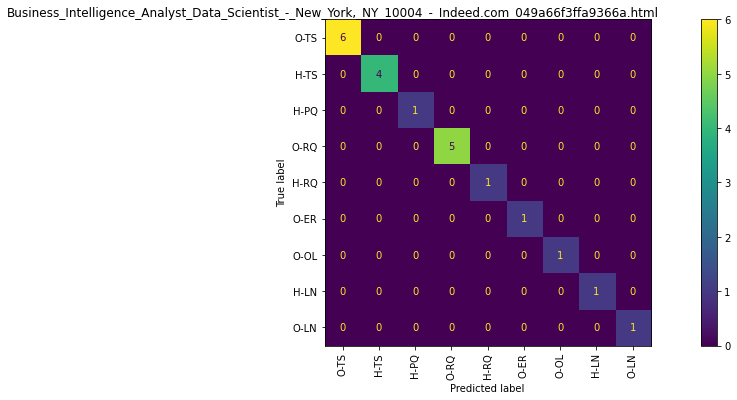

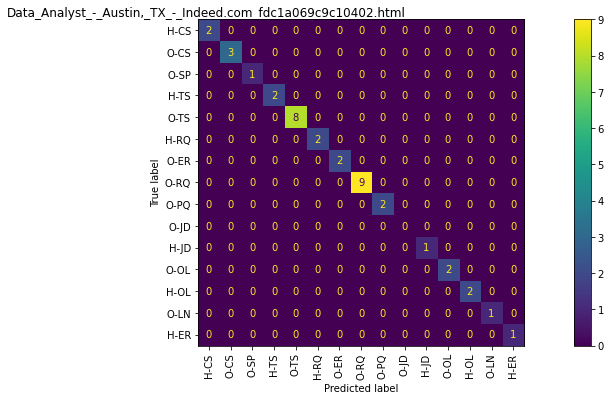

In [6]:

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

for file_name in file_names_list:
    y_true = []
    feature_dict_list = HEADER_PATTERN_DICT[file_name]
    for feature_dict in feature_dict_list:
        sent_str = feature_dict['child_str']
        pos_symbol = POS_DICT[sent_str]
        y_true.append(pos_symbol)
    y_pred = crf.CRF.predict_single(xseq=feature_dict_list)
    seen = set()
    seen_add = seen.add
    label_list = [x for x in y_true if not (x in seen or seen_add(x))]
    cm = confusion_matrix(y_true, y_pred, labels=label_list)
    fig, ax = plt.subplots(figsize=(18, 6))
    cm_display = ConfusionMatrixDisplay(cm).plot(ax=ax)
    xticklabels_list = ax.set_xticklabels(label_list, rotation='vertical')
    yticklabels_list = ax.set_yticklabels(label_list)
    plt.suptitle(t=file_name, x=0.5, y=0.91)

In [ ]:

from IPython.display import HTML, display

for file_name in file_names_list:
    y_true = []
    feature_dict_list = HEADER_PATTERN_DICT[file_name]
    for feature_dict in feature_dict_list:
        sent_str = feature_dict['child_str']
        pos_symbol = POS_DICT[sent_str]
        y_true.append(pos_symbol)
    y_pred = crf.CRF.predict_single(xseq=feature_dict_list)
    print(file_name)
    print(y_true)
    
    # Get the child strings list for the chosen file
    child_strs_list = [feature_dict['child_str'] for feature_dict in feature_dict_list]

    # Get the child tags list for the file
    child_tags_list = [feature_dict['initial_tag'] for feature_dict in feature_dict_list]

    for child_tag, pos_symbol, pos_symbol_pred, child_str in zip(child_tags_list, y_true, y_pred,
                                                                 child_strs_list):
        print(f'<{child_tag}> "{pos_symbol}" (Predicted: "{pos_symbol_pred}")')
        display(HTML(child_str))

In [9]:

for feature_tuple in [crf.hc.get_feature_tuple(feature_dict) for feature_dict in feature_dict_list]:
    initial_tag = feature_tuple[0]
    html_str = feature_tuple[1]
    pos_symbol = feature_tuple[2]
    print(html_str)

<b>About Pensa Systems</b>
<p>Pensa is an Austin-headquartered tech company and a leading innovator in autonomous perception systems for retail inventory visibility. Our system uses breakthrough technology including artificial intelligence, autonomous drones and computer vision to understand what is on store shelves. We are building really cool things that are disrupting the multi-trillion-dollar global retail industry. Our in-store inventory data-as-a-service offering provides critical benefits to very large consumer-packaged goods manufacturers and their retailer partners.</p>
<p>Today we are practicing social distancing and mostly work remotely, but when we are in the office we have snacks in the kitchen, beer in the fridge and flexible work hours. Although we work hard, we don’t get too wrapped up with protocol or bureaucracy. We appreciate diversity of all stripes and are an equal opportunity employer.</p>
<p>If you would like to know more about us, please visit www.pensasystems.c